# Complex Bayesian Network notebook

#### Import dependencies

In [206]:
# Import dependencies
#%pip install pgmpy
#%pip install tabulate
#%pip install pandas
#%pip install networkx
#%pip install matplotlib

#### Load libraries

In [207]:
# Load libraries
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sklearn

## Data import and cleaning

#### Import BigPerf data

In [208]:
# Import data
df = pd.read_csv("C:\\Users\\Keir McGlinn-Shaw\\Documents\\Stage-3\\Dissertation\\Data\\Use\\BigPerfMetrics.csv")

df.head()

,Block_ID,HDFS_BW,HDFSTranmissionTime,Mapper_ID,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_ID,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_ID.1,Block_BW,BlockTransmissionTime,TransactionTime
0,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer0,341739,480,3.80,250.14,reducer0_Block_1,0.0,0.00,1578.79
1,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer1,150000,120,50.00,18.99,reducer1_Block_1,50.0,20.00,1007.64
2,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer2,382530,480,4.48,212.22,reducer2_Block_1,3.7,270.02,1811.61
3,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer3,150000,120,5.88,161.57,reducer3_Block_1,3.7,270.02,1400.96
4,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,18.41,4.16,reducer4,457419,480,5.88,161.53,reducer4_Block_1,3.7,270.02,1761.83


#### Clean data of unwanted variables and missing values

In [209]:
# Clean data
df.dropna()

df.drop(labels=['Block_ID', 'Mapper_ID', 'Reducer_ID', 'Block_ID.1'], axis=1, inplace=True)

df.head()

,HDFS_BW,HDFSTranmissionTime,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_BW,BlockTransmissionTime,TransactionTime
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83


#### Rename columns to better fit in drawn charts and for ease of use

In [210]:
# Rename column headers to abbreviations

nodes = ['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT', 'TT']

df.columns = nodes

df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83
5,11.81,80.63,652289,765.49,18.41,4.16,150000,120,6.98,136.24,3.7,270.02,1376.54
6,11.81,80.63,652289,765.49,18.41,4.16,563904,480,3.80,250.14,3.7,270.02,1850.44
7,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63
8,11.81,80.63,652289,765.49,18.41,4.16,430890,480,3.80,250.14,3.7,270.02,1850.44
9,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63


#### Define funtion to discretise data into three catagories

In [211]:
'''
Splits data into three bins of equal size using: https://pandas.pydata.org/docs/reference/api/pandas.cut.html
'''
def split_tertiles(df):
    tertile_labels = ['Very Low', 'Low', 'High', 'Very High']

    tert_df = pd.DataFrame()

    for column_name in df:
        tert_df[column_name] = pd.cut(df[column_name], 4, labels=tertile_labels, ordered=True)

    # Change type of values stored in dataframe to avoid errors arrising from using the Category type when the dataframe is fed into the pgmpy.metrics.metrics correlation_score function
    tert_df = tert_df.astype('object')

    return tert_df

#### Discretise data into catagories

In [212]:
cat_df = split_tertiles(df)

cat_df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,Very High,Very Low,Very Low,Very Low,Very High,Very Low,Low,Very High,Very Low,Very High,Very Low,Very Low,Low
1,Very High,Very Low,Very Low,Very Low,Very High,Very Low,Very Low,Very Low,Low,Very Low,Very High,Very Low,Very Low
2,Very High,Very Low,Very Low,Very Low,High,Very Low,High,Very High,Very Low,Very High,Very Low,Very High,Low
3,Very High,Very Low,Very Low,Very Low,High,Very Low,Very Low,Very Low,Very Low,High,Very Low,Very High,Very Low
4,Very High,Very Low,Very Low,Very Low,High,Very Low,High,Very High,Very Low,High,Very Low,Very High,Low
5,Very High,Very Low,Very Low,Very Low,High,Very Low,Very Low,Very Low,Very Low,High,Very Low,Very High,Very Low
6,Very High,Very Low,Very Low,Very Low,High,Very Low,Very High,Very High,Very Low,Very High,Very Low,Very High,Low
7,Very High,Very Low,Very Low,Very Low,High,Very Low,Very Low,Very Low,Very High,Very Low,Very Low,Very High,Very Low
8,Very High,Very Low,Very Low,Very Low,High,Very Low,High,Very High,Very Low,Very High,Very Low,Very High,Low
9,Very High,Very Low,Very Low,Very Low,High,Very Low,Very Low,Very Low,Very High,Very Low,Very Low,Very High,Very Low


In [213]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(cat_df, test_size=0.2, random_state=20)

In [214]:
from itertools import combinations

import networkx as nx
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from pgmpy.models import BayesianModel, NaiveBayes, BayesianNetwork
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.estimators.CITests import chi_square, cressie_read, freeman_tuckey, g_sq, independence_match, log_likelihood
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling

In [215]:
pc = PC(data=training_data)
model = pc.estimate(variant='stable', ci_test=chi_square, return_type='dag', significance_level=0.25)

  0%|          | 0/5 [00:00<?, ?it/s]

In [216]:
bayes_model = BayesianNetwork(model)

bayes_model.add_edge('MBW', 'MTT')

In [217]:
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML

# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

bayes_model.cpds = []

bayes_model.fit(data=training_data,
    estimator=BayesianEstimator,
    prior_type='BDeu',
    complete_samples_only=False)

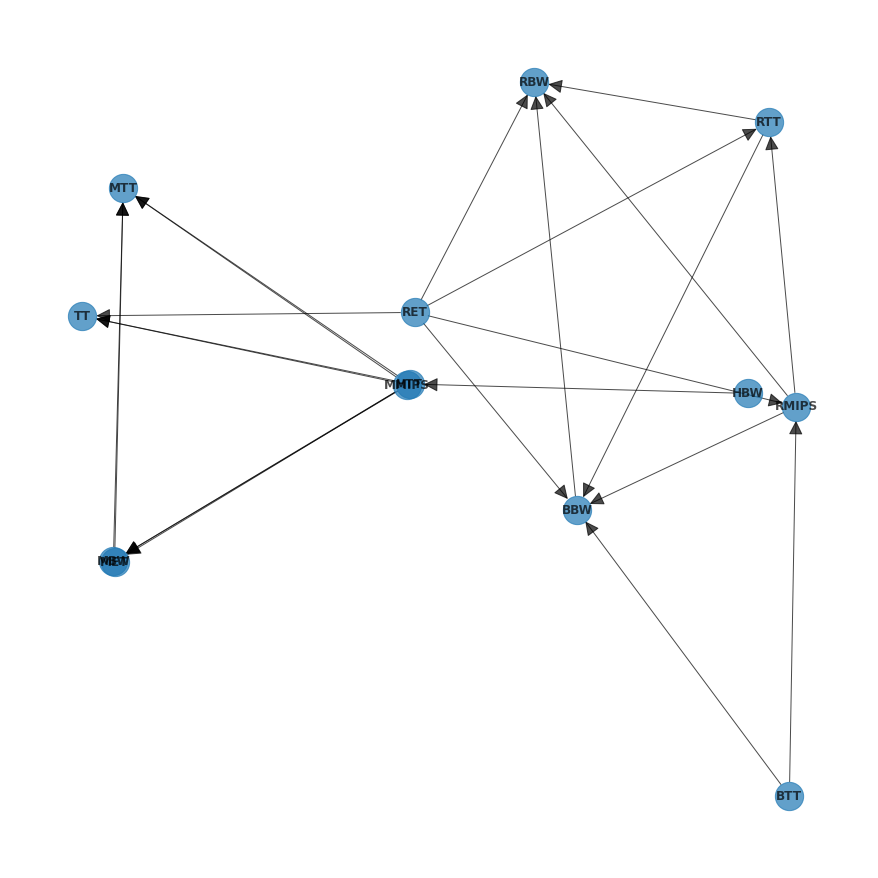

In [218]:
plt.figure(3,figsize=(12,12)) 
G = nx.DiGraph()
G.add_edges_from(bayes_model.edges)
G.add_nodes_from(bayes_model.nodes)
pos = nx.kamada_kawai_layout(G)

nx.draw(G, pos=pos, with_labels=True, arrowsize=30, node_size=800, alpha=0.7, font_weight="bold")  # Draw the original graph
plt.show()

In [219]:
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

for column in testing_data:
    predict_data = testing_data.copy()
    #test_data_without_unmodelled = testing_data.copy()
    #test_data_without_unmodelled.drop('MBW', axis=1, inplace=True)
    predict_data.drop(column, axis=1, inplace=True)
    #predict_data.drop('MBW', axis=1, inplace=True)
    
    
    y_pred = bayes_model.predict(predict_data)

    accuracy = accuracy_score(testing_data[column], y_pred)
    
    # if len(testing_data[column].unique()) == 2:
    #     precision = precision_score(testing_data[column], y_pred, pos_label='Low') #pos_label=testing_data[column].unique()
    #     f1 = f1_score(testing_data[column], y_pred, pos_label='Low')
    #     recall = recall_score(testing_data[column], y_pred, pos_label='Low')

    # else:
    #     precision = precision_score(testing_data[column], y_pred, average='micro') #pos_label=testing_data[column].unique()
    #     f1 = f1_score(testing_data[column], y_pred, average='micro')
    #     recall = recall_score(testing_data[column], y_pred, average='micro')

    #print(f'{column} F1 score: {f1}')
    print(f'{column} Accuracy score: {accuracy}')
    #print(f'{column} Precision score: {precision}')
    #print(f'{column} Recall score: {recall}')

  0%|          | 0/150 [00:00<?, ?it/s]

HBW Accuracy score: 0.9940944881889764


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/152 [00:00<?, ?it/s]

HTT Accuracy score: 0.9940944881889764


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

MMIPS Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

MET Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/138 [00:00<?, ?it/s]

MBW Accuracy score: 0.9173228346456693


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/101 [00:00<?, ?it/s]

MTT Accuracy score: 0.7224409448818898


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/134 [00:00<?, ?it/s]

RMIPS Accuracy score: 0.8917322834645669


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

RET Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

RBW Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/141 [00:00<?, ?it/s]

RTT Accuracy score: 0.8996062992125984


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

BBW Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

BTT Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/137 [00:00<?, ?it/s]

TT Accuracy score: 0.8051181102362205


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


In [220]:
f1 = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
acc = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
pr = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
recall = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
ls = log_likelihood_score(model=bayes_model, data=testing_data)
ss = structure_score(model=bayes_model, data=testing_data, scoring_method='bdeu')


print(f'F1 score: {f1}')
print(f'Accuracy score: {acc}')
print(f'Precision score: {pr}')
print(f'Recall score: {recall}')
print(f'Log-likilihood score: {ls}')
print(f'Strcture score: {ss}')

F1 score: 0.782608695652174
Accuracy score: 0.8076923076923077
Precision score: 0.6428571428571429
Recall score: 1.0
Log-likilihood score: -2906.6835940717015
Strcture score: -3214.788412626408


In [221]:
def store_metrics(metrics_file_name, model_name, f1, accuracy, precision, recall, log_likelihood_score, structure_score):
    try: 
        df = pd.read_csv('Model-metrics.csv', header=0, index_col=False)
    except:
        df_columns = ['Model', 'F1', 'Accuracy', 'Precision', 'Recall', 'Log likelihood score', 'Structure score']

        df = pd.DataFrame(columns=df_columns)

    else:
        df = df[df.Model != model_name]
        
    new_row = {'Model': model_name, 'F1': f1, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'Log likelihood score': log_likelihood_score, 'Structure score': structure_score}

    df = df.append(new_row, ignore_index=True)

    # Write to file
    df.to_csv(metrics_file_name, index=False)


In [222]:
model_name = 'Constraint-based CBN'
metrics_file_name = 'Model-metrics.csv'

store_metrics(metrics_file_name=metrics_file_name, model_name=model_name, f1=f1, accuracy=acc, precision=pr, recall=recall, log_likelihood_score=ls, structure_score=ss)

C:\Users\KEIRMC~1\AppData\Local\Temp/ipykernel_3708/3521155595.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


In [223]:
print(f'Check model: {bayes_model.check_model()}\n')
for cpd in bayes_model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of RMIPS:
+------------------+-----+----------------------+
| BTT              | ... | BTT(Very Low)        |
+------------------+-----+----------------------+
| RET              | ... | RET(Very Low)        |
+------------------+-----+----------------------+
| RMIPS(High)      | ... | 0.001560549313358302 |
+------------------+-----+----------------------+
| RMIPS(Low)       | ... | 0.001560549313358302 |
+------------------+-----+----------------------+
| RMIPS(Very High) | ... | 0.001560549313358302 |
+------------------+-----+----------------------+
| RMIPS(Very Low)  | ... | 0.9953183520599251   |
+------------------+-----+----------------------+ 

CPT of BBW:
+----------------+-----+------------------------+
| BTT            | ... | BTT(Very Low)          |
+----------------+-----+------------------------+
| RET            | ... | RET(Very Low)          |
+----------------+-----+------------------------+
| RMIPS          | ... | RMIPS(Very Low)        |
+--